In [1]:
import os
%pwd

'd:\\ML-Projects\\03-Air-Quality-Index-Predictor\\research'

In [2]:
os.chdir("../")
%pwd

'd:\\ML-Projects\\03-Air-Quality-Index-Predictor'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product


d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_data = pd.read_csv(r"artifacts\data_transformation\train_dataset.csv", parse_dates=['date'])
test_data = pd.read_csv(r"artifacts\data_transformation\test_dataset.csv", parse_dates=['date'])


In [5]:
train_city = train_data[train_data['city'] == 'Delhi']
test_city = train_data[train_data['city'] == 'Delhi']
    
train_city.set_index('date', inplace=True)
test_city.set_index('date', inplace=True)
    
#     # Set the frequency explicitly to weekly ('W')
# train_city = train_city.resample(rule = 'W').mean()
# test_city = test_city.resample(rule = 'W').mean()
train_city



,city,CO,NO2,O3,PM10,PM2.5,SO2,AQI_calculated
date,,,,,,,,
2021-01-01,Delhi,3.331,66.434,38.211,388.088,336.690,60.726,467.0
2021-01-02,Delhi,3.194,63.788,39.381,376.893,327.225,56.732,459.0
2021-01-03,Delhi,3.231,63.589,39.459,378.868,328.453,57.186,460.0
2021-01-04,Delhi,3.314,64.599,39.286,386.956,335.072,58.255,465.0
2021-01-05,Delhi,3.328,64.849,40.323,394.030,341.647,58.485,470.0
...,...,...,...,...,...,...,...,...
2023-12-26,Delhi,5.445,117.384,15.928,714.933,623.460,100.577,756.0
2023-12-27,Delhi,5.499,119.612,14.049,740.317,649.319,104.887,788.0
2023-12-28,Delhi,5.495,121.345,9.708,745.181,658.972,112.338,794.0


In [6]:
def plot_forecasts(train, test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train.values, label='Train')
    plt.plot(test.index, test.values, label='Test')
    plt.plot(test.index, predictions, label='Predictions', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

def city_forecasting_with_plot(city, train, test, model_func, plot=True, **kwargs):
    train_city = train[train['city'] == city]
    test_city = test[test['city'] == city]
    
    train_city.set_index('date', inplace=True)
    test_city.set_index('date', inplace=True)

    train_series = train_city['AQI_calculated']
    test_series = test_city['AQI_calculated']
    
    # Set the frequency explicitly to weekly ('W')
    train_series = train_series.resample(rule = 'W').mean()
    test_series = test_series.resample(rule = 'W').mean()
    
    forecast = model_func(train_series, test_series, **kwargs)
    if forecast is None:
        print(f"Warning: Forecast for AQI_calculated is None")
        return {}, {}
    
    forecasts = {'AQI_calculated': forecast}
    
    try:
        rmse, mae = evaluate_forecast(test_series, forecast)
        metrics = {'AQI_calculated': {'RMSE': rmse, 'MAE': mae}}
    except Exception as e:
        print(f"Error in evaluating forecast for AQI_calculated: {e}")
        return {}, {}
    
    if plot:
        plot_forecasts(train_series, test_series, forecast, title=f'{city} - AQI_calculated')
    
    return forecasts, metrics


## 1. Exponential Smoothing

In [7]:
# Exponential Smoothing (ETS)
def ets_forecast(train, test, seasonal='mul', seasonal_periods=12):
    model = ExponentialSmoothing(train, trend='mul', seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Forecasting for Delhi using Exponential Smoothing (ETS)


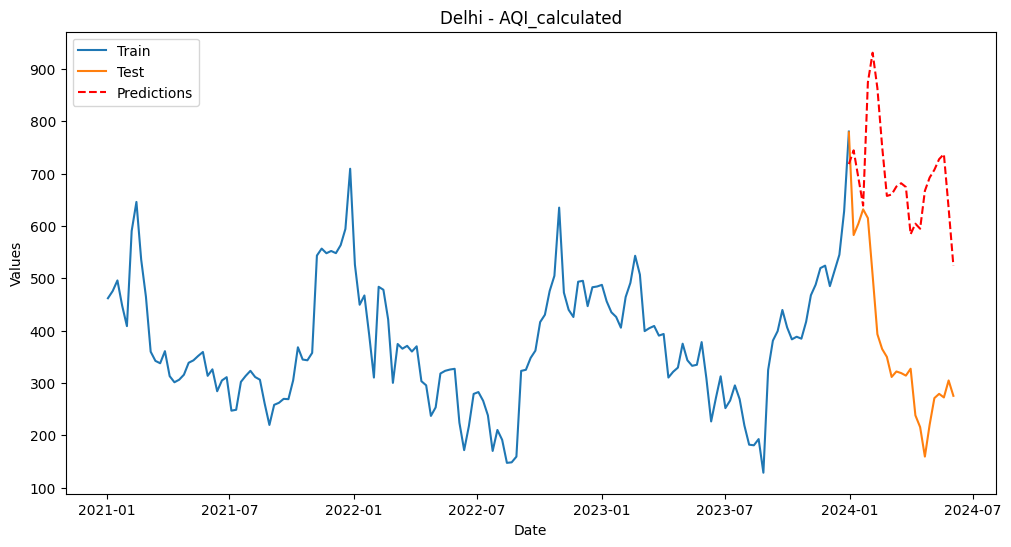

ETS Metrics: {'AQI_calculated': {'RMSE': 352.7497340882668, 'MAE': 326.17926120164947}}


In [8]:

# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using Exponential Smoothing (ETS)")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, ets_forecast, seasonal='mul', seasonal_periods=52)
print("ETS Metrics:", ets_metrics)




### Improved

In [9]:
def ets_forecast_updated(train, test):
    param_grid = {
        'trend': ['add', 'mul', None],
        'seasonal': ['add', 'mul', None],
        'seasonal_periods': [12, 52]  # Adjust as needed
    }
    
    best_score = float('inf')
    best_params = None
    best_forecast = None
    
    # Check if train data is strictly positive
    is_positive = np.all(train > 0)
    
    for trend, seasonal, seasonal_periods in product(param_grid['trend'], param_grid['seasonal'], param_grid['seasonal_periods']):
        if not is_positive and (trend == 'mul' or seasonal == 'mul'):
            print(f"Skipping combination trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} due to non-positive values in the data")
            continue
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                
                # Clipping the train data to avoid extreme values causing overflow
                clipped_train = train.clip(lower=-1e10, upper=1e10)
                
                model = ExponentialSmoothing(clipped_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                score = mean_squared_error(test, forecast)
                
                if score < best_score:
                    best_score = score
                    best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': seasonal_periods}
                    best_forecast = forecast
        except Exception as e:
            print(f"Error fitting model with trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}: {e}")
            continue
    
    print(f"Best Parameters: {best_params}")
    return best_forecast


Forecasting for Delhi using Exponential Smoothing (ETS)
Best Parameters: {'trend': None, 'seasonal': 'mul', 'seasonal_periods': 52}


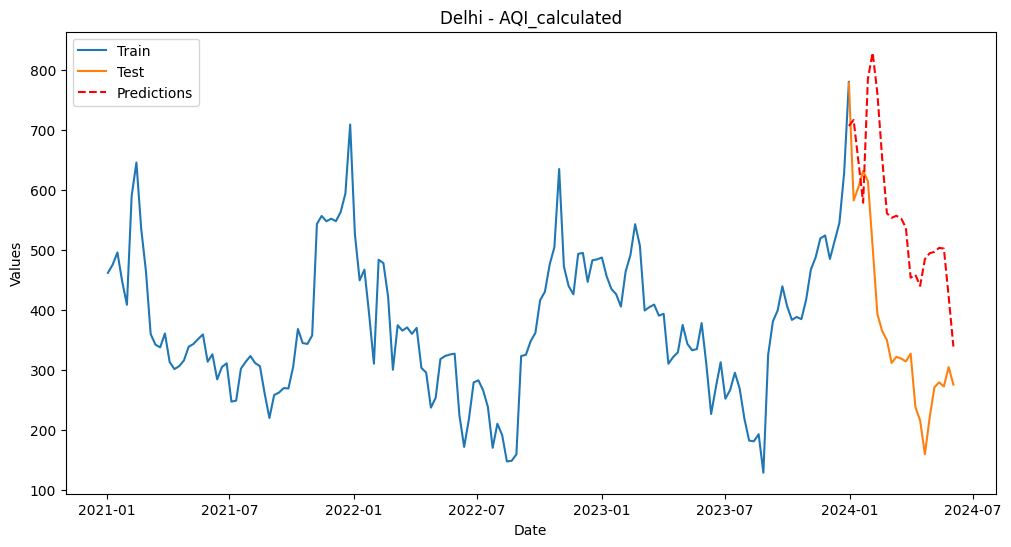

ETS Metrics: {'AQI_calculated': {'RMSE': 219.91119371883767, 'MAE': 201.44485875674656}}


In [10]:

# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using Exponential Smoothing (ETS)")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, ets_forecast_updated)
print("ETS Metrics:", ets_metrics)


## 2. Arima

In [11]:
from pmdarima import auto_arima

In [13]:
train_city = train_data[train_data['city'] == 'Delhi']
test_city = test_data[test_data['city'] == 'Delhi']

train_city.set_index('date', inplace=True)
test_city.set_index('date', inplace=True)

train_series = train_city['AQI_calculated']
test_series = test_city['AQI_calculated']

# Set the frequency explicitly to weekly ('W')
train_series = train_series.resample(rule = 'W').mean()
test_series = test_series.resample(rule = 'W').mean()
df = pd.concat([train_series,test_series])
auto_arima(y=df,start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=False, m=52)


d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (52) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True)

In [14]:
# ARIMA
def arima_forecast(train, test, order=(3,0,0)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using ARIMA


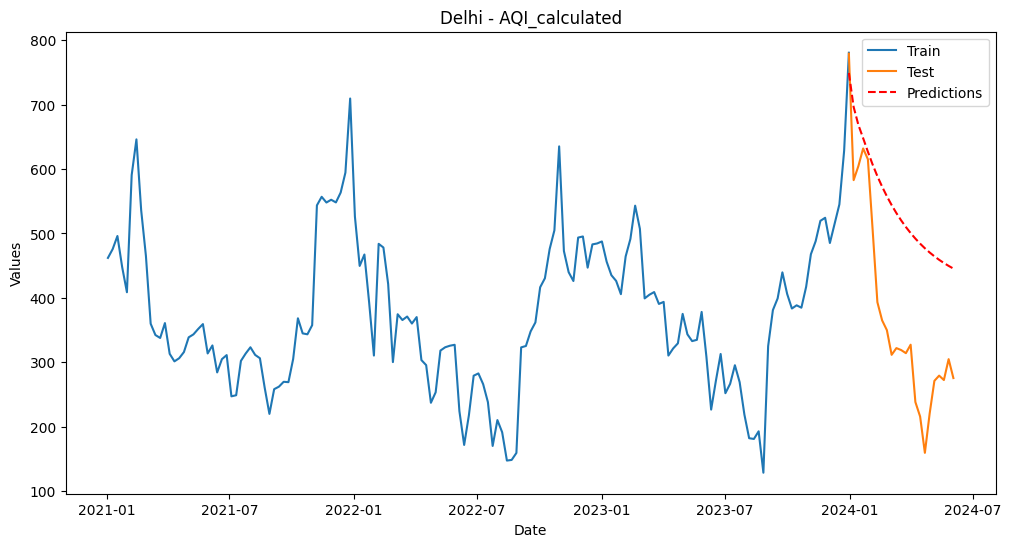

ETS Metrics: {'AQI_calculated': {'RMSE': 187.9269133312949, 'MAE': 170.39034044259938}}


In [15]:
# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using ARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, arima_forecast)
print("ETS Metrics:", ets_metrics)

## 3. SARIMA

In [16]:
auto_arima(y=df,start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=52)

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True)

In [25]:
test_data

,date,city,CO,NO2,O3,PM10,PM2.5,SO2,AQI_calculated
0,2023-12-31,Jaipur,1.0800,18.1130,79.8275,213.0195,201.2320,10.8840,362.0
1,2023-12-31,Delhi,5.4700,118.4980,11.8785,732.9390,651.1715,102.7320,779.0
2,2023-12-31,Pune,1.4430,38.9955,49.2935,182.1735,162.4345,21.8660,333.0
3,2023-12-31,Surat,0.9730,25.4540,59.4595,213.7550,196.4040,30.2705,359.0
4,2023-12-31,Mumbai,2.9715,89.8080,92.9000,463.1705,405.2790,75.4795,519.0
...,...,...,...,...,...,...,...,...,...
1515,2024-05-30,Chennai,0.5190,18.4500,100.9630,44.6260,36.4490,26.2740,101.0
1516,2024-05-30,Bangalore,0.3720,11.5460,32.6870,5.9130,3.6310,4.3190,33.0
1517,2024-05-30,Ahmedabad,0.3630,13.4810,64.5420,62.6500,23.6300,21.3090,65.0
1518,2024-05-30,Pune,0.2470,3.4630,54.8510,42.4520,13.3580,3.4820,55.0


In [36]:
pred_start_date = pd.to_datetime(test_data.iloc[0,0])
pred_end_date = pd.to_datetime(test_data.iloc[-1,0])
print(pred_start_date)
print(pred_end_date)

2023-12-31 00:00:00
2024-05-30 00:00:00


In [37]:

def sarima_forecast(train, test, order=(1,0,0), seasonal_order=(2,0,0,52)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    predictions = results.predict(start=pred_start_date, end=pred_end_date, typ='levels').rename('predictions')
    # forecast = model_fit.predict(steps=len(test),typ='levels')
    return predictions


Forecasting for Delhi using SARIMA


d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


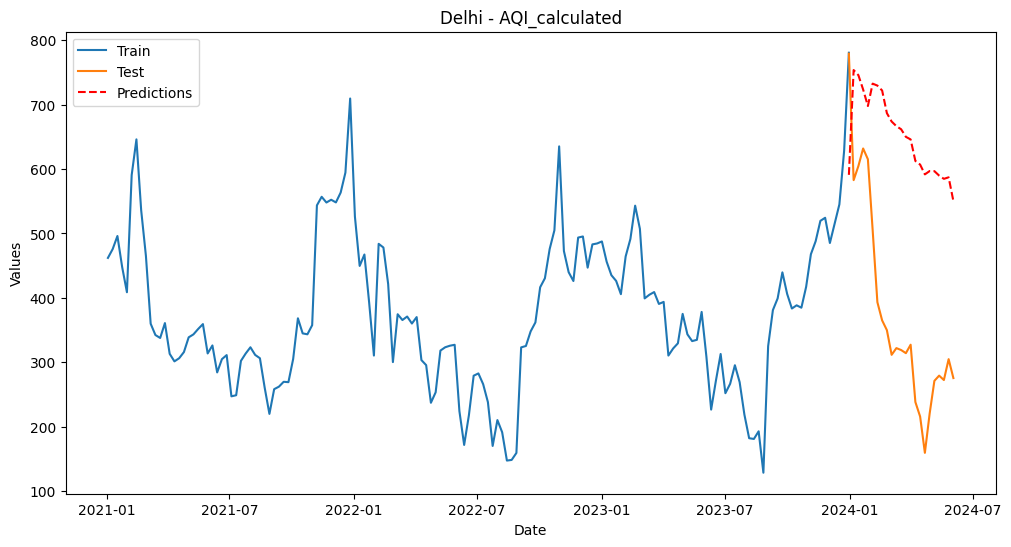

ETS Metrics: {'AQI_calculated': {'RMSE': 306.6828877860595, 'MAE': 291.9191575254919}}


In [38]:

print(f"Forecasting for {city_name} using SARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, sarima_forecast)
print("ETS Metrics:", ets_metrics)

## 4. Prophet


In [35]:
def prophet_forecast(train, test):
    df = train.reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    return forecast['yhat'][-len(test):].values

14:43:59 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for Delhi using Prophet


14:44:00 - cmdstanpy - INFO - Chain [1] done processing


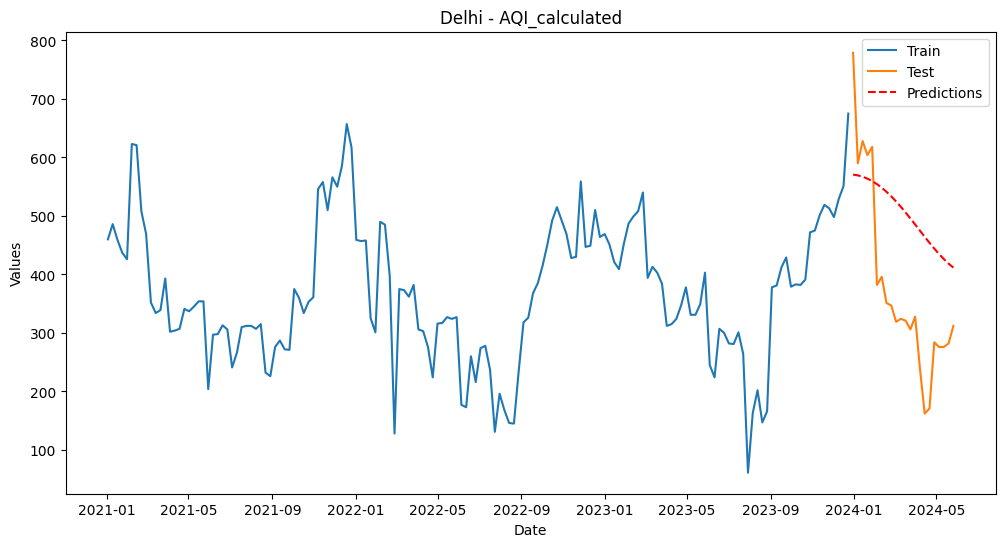

ETS Metrics: {'AQI_calculated': {'RMSE': 175.74384615595628, 'MAE': 161.17322887608947}}


In [36]:
print(f"Forecasting for {city_name} using Prophet")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, prophet_forecast)
print("ETS Metrics:", ets_metrics)

### Improved

In [43]:


from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np

def prophet_forecast_tuned(train, test):
    df_train = train.reset_index()
    df_train.columns = ['ds', 'y']
    df_test = test.reset_index()
    df_test.columns = ['ds', 'y']

    param_grid = {
        'changepoint_prior_scale': [0.05, 0.1, 0.5],
        'seasonality_prior_scale': [5, 10, 20],
        'n_changepoints': [10, 20, 30],
        'daily_seasonality': [True, False]
    }
    
    best_model = None
    best_mse = float('inf')  # Initialize with a high value

    for params in ParameterGrid(param_grid):
        model = Prophet(**params)
        model.fit(df_train)
        
        forecast = model.predict(df_test)
        mse = mean_squared_error(df_test['y'], forecast['yhat'])
        
        if mse < best_mse:
            best_mse = mse
            best_model = model

    future = best_model.make_future_dataframe(periods=len(df_test))
    forecast = best_model.predict(future)
    return forecast['yhat'][-len(df_test):].values


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Delhi using Prophet


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1]

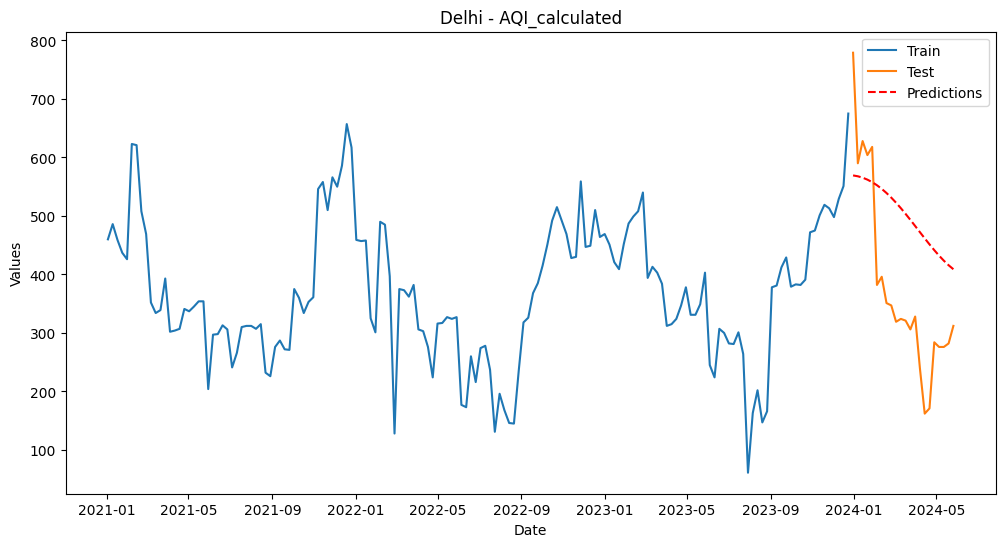

ETS Metrics: {'AQI_calculated': {'RMSE': 173.90187730380106, 'MAE': 159.6433410022417}}


In [45]:
print(f"Forecasting for {city_name} using Prophet")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, prophet_forecast_tuned)
print("ETS Metrics:", ets_metrics)